In [2]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from causalml.metrics import plot_qini

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/CIPE/CIPE_data.csv'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(file_path)

df.head(10)
#onehot encoding of state aand platform
categorical_features = ['state', 'platform']
numerical_features = ['age', 'is_new_customer', 'total_spend', 'recency', 'pages_viewed']
target_col = 'conversion'
treatment_col = 'treatment'
df_processed = pd.get_dummies(df,columns=categorical_features,drop_first=True)
df_processed.head()
treatment_df = df_processed[df_processed['treatment'] == 1].copy()
control_df = df_processed[df_processed['treatment'] == 0].copy()


In [4]:
features = [col for col in df_processed.columns if col not in ['segment', 'treatment', 'conversion']]
target = 'conversion'
X_treat = treatment_df[features]
y_treat = treatment_df[target]
X_ctrl = control_df[features]
y_ctrl = control_df[target]
X_train_treat, X_test_treat, y_train_treat, y_test_treat = train_test_split(X_treat, y_treat, test_size=0.25, random_state=42)

X_train_ctrl, X_test_ctrl, y_train_ctrl, y_test_ctrl = train_test_split(X_ctrl, y_ctrl, test_size=0.25, random_state=42)



In [5]:
xgb_treat = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_treat.fit(X_train_treat, y_train_treat)
xgb_ctrl = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

xgb_ctrl.fit(X_train_ctrl, y_train_ctrl)

X_test_all = pd.concat([X_test_treat, X_test_ctrl])
y_test_all = pd.concat([y_test_treat, y_test_ctrl])



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:08:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:08:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [6]:
treatment_flag_test = df_processed.loc[X_test_all.index, 'treatment']

pred_prob_treat = xgb_treat.predict_proba(X_test_all)[:, 1]
pred_prob_ctrl = xgb_ctrl.predict_proba(X_test_all)[:, 1]

uplift_scores = pred_prob_treat - pred_prob_ctrl



In [7]:
results_df = pd.DataFrame({
    'y_true': y_test_all,
    'treatment': treatment_flag_test,
    'p_treat': pred_prob_treat,
    'p_ctrl': pred_prob_ctrl,
    'uplift_score': uplift_scores})
results_df = results_df.reset_index(drop=True)


print(results_df.head())




   y_true  treatment   p_treat    p_ctrl  uplift_score
0       1          1  0.793435  0.859161     -0.065726
1       0          1  0.424292  0.823685     -0.399394
2       0          1  0.076952  0.031180      0.045772
3       1          1  0.363047  0.764143     -0.401096
4       0          1  0.052076  0.016040      0.036036


In [12]:
import numpy as np

In [13]:
def plot_custom_qini_curve(results_df):
    """
    Calculates and plots a custom Qini curve and the AUUC.
    """

    sorted_df = results_df.sort_values(by='uplift_score', ascending=False).reset_index(drop=True)


    treat_df = sorted_df[sorted_df['treatment'] == 1]
    ctrl_df = sorted_df[sorted_df['treatment'] == 0]

    sorted_df['cum_treat_conv'] = np.where(sorted_df['treatment'] == 1, sorted_df['y_true'], 0).cumsum()
    sorted_df['cum_ctrl_conv'] = np.where(sorted_df['treatment'] == 0, sorted_df['y_true'], 0).cumsum()


    sorted_df['cum_treat_pop'] = sorted_df['treatment'].cumsum()
    sorted_df['cum_ctrl_pop'] = (1 - sorted_df['treatment']).cumsum()


    sorted_df['cum_treat_pop'] = sorted_df['cum_treat_pop'].replace(0, 1)
    sorted_df['cum_ctrl_pop'] = sorted_df['cum_ctrl_pop'].replace(0, 1)


    qini_curve = (sorted_df['cum_treat_conv'] / sorted_df['cum_treat_pop']) - \
                 (sorted_df['cum_ctrl_conv'] / sorted_df['cum_ctrl_pop'])
    qini_curve *= (sorted_df.index + 1) / len(sorted_df)


    auuc = np.trapz(qini_curve, dx=1/len(qini_curve))


    plt.figure(figsize=(8, 6))
    x_axis = np.arange(len(qini_curve)) + 1
    plt.plot(x_axis, qini_curve, color='orange', label=f'Model (AUUC = {auuc:.4f})')
    plt.plot([0, len(sorted_df)], [0, qini_curve.iloc[-1]], color='blue', linestyle='--', label='Random')

    plt.xlabel('Number of Customers Targeted (sorted by uplift)')
    plt.ylabel('Incremental Conversions')
    plt.title('Qini Curve for CIPE Model', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


/tmp/ipython-input-13-1329103402.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auuc = np.trapz(qini_curve, dx=1/len(qini_curve))


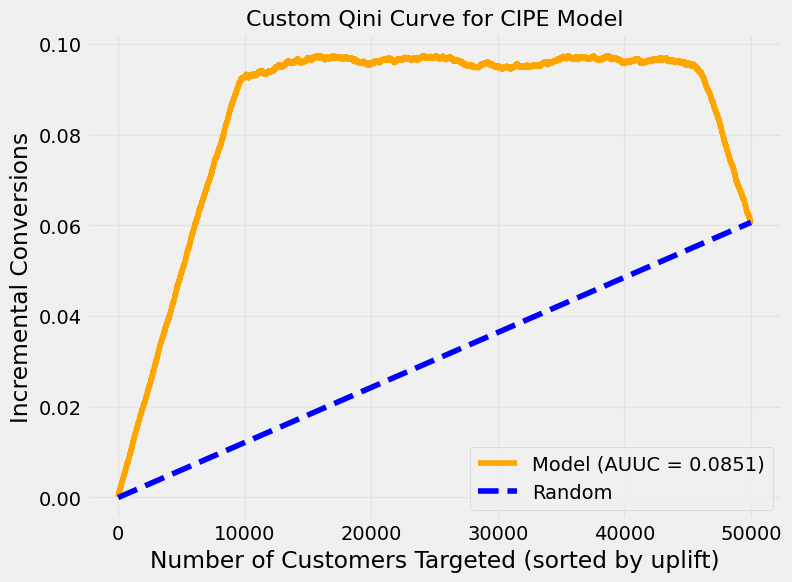

In [14]:
plot_custom_qini_curve(results_df)

In [15]:
%%capture
!pip install shap

Analyzing the Treatment Model...
SHAP Summary Plot for Treatment Group:


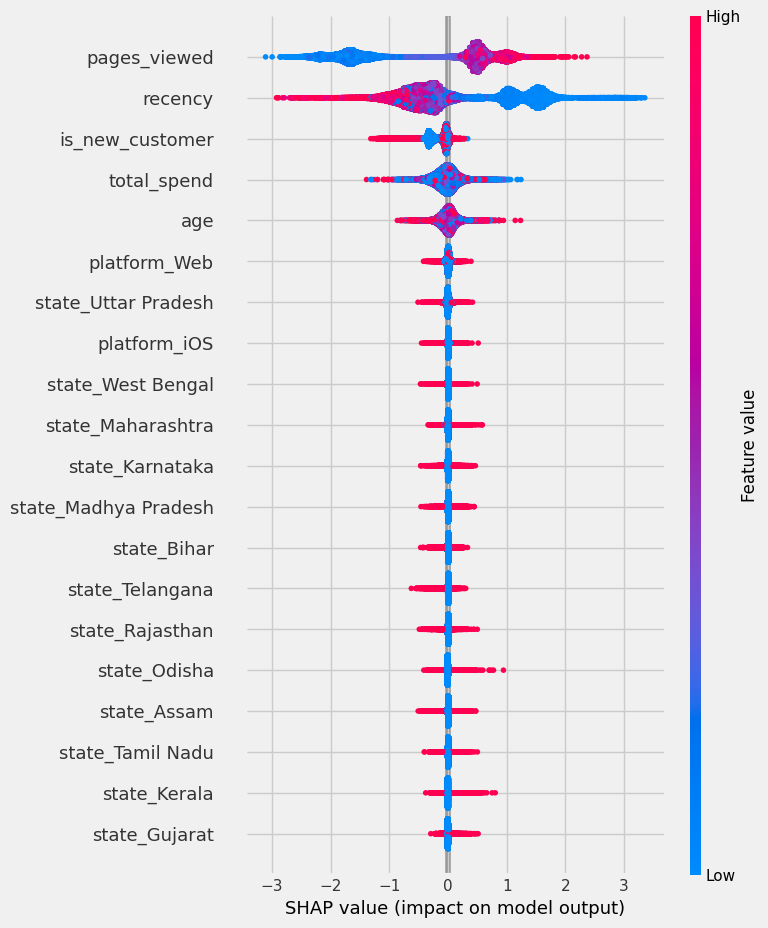


Analyzing the Control Model...
SHAP Summary Plot for Control Group:


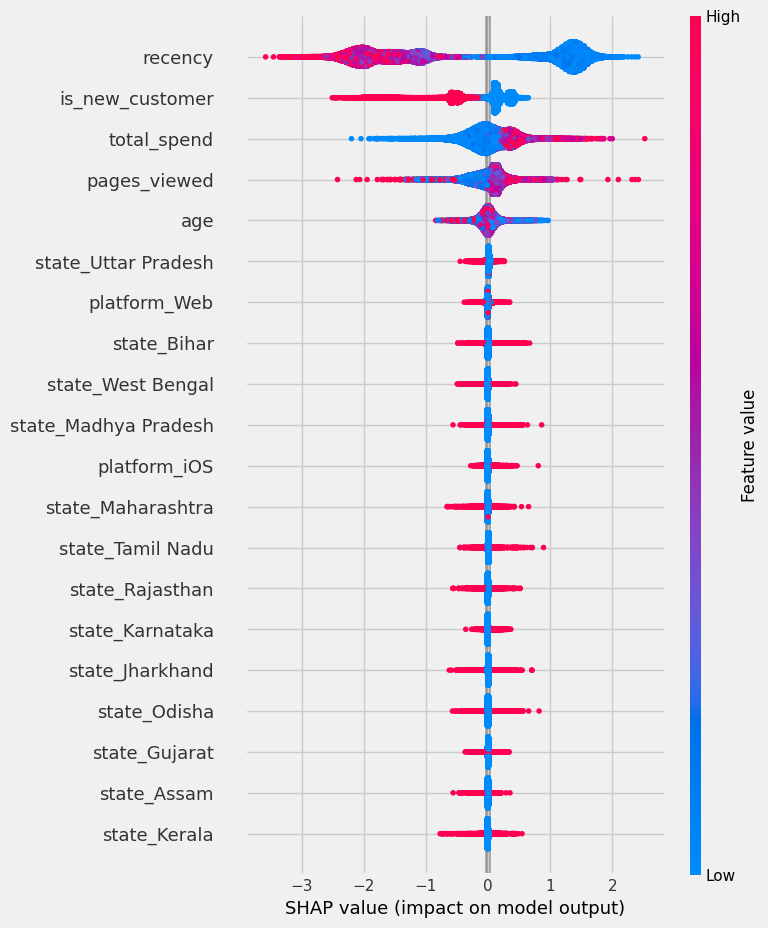

In [16]:
import shap

print("Analyzing the Treatment Model...")
explainer_treat = shap.Explainer(xgb_treat)
shap_values_treat = explainer_treat(X_train_treat)

print("SHAP Summary Plot for Treatment Group:")
shap.summary_plot(shap_values_treat, X_train_treat, plot_type="dot")



print("\nAnalyzing the Control Model...")
explainer_ctrl = shap.Explainer(xgb_ctrl)
shap_values_ctrl = explainer_ctrl(X_train_ctrl)

print("SHAP Summary Plot for Control Group:")
shap.summary_plot(shap_values_ctrl, X_train_ctrl, plot_type="dot")